In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

import os

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from IPython.display import Image
import tifffile as tiff

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.optim import lr_scheduler

In [ ]:
# Create a directory to save generated images
os.makedirs("02_mnist_images", exist_ok=True)

In [ ]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=42):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.Resize(64),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,)),
                    ])

    transform_valid = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])


    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler,pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader


In [ ]:
batch_sz=128 #
train_loader, valid_loader, test_loader=mnist(batch_sz)

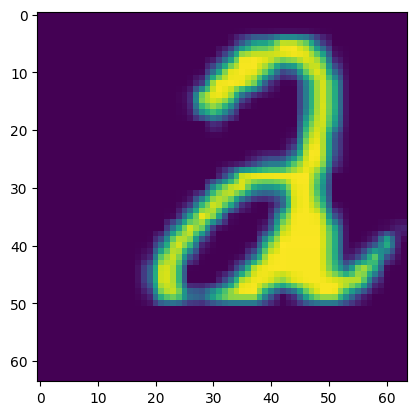

In [ ]:
batch = next(iter(train_loader))
plt.imshow(batch[0][0].permute((1,2,0)))

In [ ]:
# Define the parameters for the training process
epochs = 51
lr = 2e-4
b1 = 0.5
b2 = 0.999
latent_dim = 64 # z size
img_size = 64
channels = 1

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()


        self.conv1 = nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0)
        self.batchnorm1 = nn.BatchNorm2d(512)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2,1)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.relu4 = nn.LeakyReLU(0.2, inplace=True)


        self.conv5 = nn.ConvTranspose2d(64, channels, 4, 2, 1)
        self.tanh = nn.Tanh()

    def forward(self, z):
        # z = 64,28

        z = z.view(z.shape[0], z.shape[1], 1, 1)

        x = self.conv1(z)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.conv2(x)

        x = self.batchnorm2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.relu4(x)

        img = self.conv5(x)

        img = self.tanh(img)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()


        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)
        self.leakyrelu1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.leakyrelu2 = nn.LeakyReLU(0.2, inplace=True)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.leakyrelu3 = nn.LeakyReLU(0.2, inplace=True)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.leakyrelu4 = nn.LeakyReLU(0.2, inplace=True)
        self.conv5 = nn.Conv2d(512, 1, 4, 2, 0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        x = self.conv1(img)
        x = self.leakyrelu1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.leakyrelu2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.leakyrelu3(x)
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.leakyrelu4(x)
        validity = self.conv5(x)
        validity = self.sigmoid(validity)
        validity = validity.view(img.shape[0], -1)  # Flatten the output

        return validity


In [ ]:

# Check if a GPU is available and if not, use a CPU
cuda = True if torch.cuda.is_available() else False


#
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
gen = Generator()
print(gen)

Generator(
  (conv1): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv5): ConvTranspose2d(64, 1, kernel_size=(4

In [ ]:
# We use binary cross-entropy loss for the adversarial loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize the generator and the discriminator
generator = Generator()
discriminator = Discriminator()

# If CUDA is available, we use it for the models and the loss function
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# We use the Adam optimizer for both the generator and the discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Initialize schedulers
scheduler_G = lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.1)
scheduler_D = lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.1)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# Initialize lists to store losses for Generator and Discriminator
g_losses = []
d_losses = []

# Training Loop
for epoch in tqdm(range(epochs)):
    g_loss_accum = 0.0
    d_loss_accum = 0.0
    num_batches = 0

    for batch in train_loader:
        imgs = batch[0]

        # Ground truths for real and fake images (real: 1, fake: 0)
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        # Configure input, this will be used for training the discriminator with real images
        real_imgs = imgs.type(Tensor)

        # Train Generator
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        # Generate a batch of images from the noise
        gen_imgs = generator(z)
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)


        g_loss.backward()
        optimizer_G.step()

        #----------------------------- Train Discriminator -----------------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)  # Loss for real images
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Accumulate losses for this batch
        g_loss_accum += g_loss.item()
        d_loss_accum += d_loss.item()
        num_batches += 1

    # Step the learning rate
    scheduler_G.step()
    scheduler_D.step()

    # Save average losses for this epoch
    g_losses.append(g_loss_accum / num_batches)
    d_losses.append(d_loss_accum / num_batches)
    # Save a batch of generated images every 10 epochs
    if epoch % 5 == 0:
        save_image(gen_imgs.data[:25], f"02_mnist_images/epoch_{epoch}.png", nrow=5, normalize=True)

 25%|██▌       | 13/51 [14:38<42:48, 67.59s/it]

In [ ]:

# Plotting the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="Generator")
plt.plot(d_losses,label="Discriminator")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# Function to unnormalize and bring back the pixel values to (0, 1)
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose to put channel last (which is the expected format for matplotlib)
    plt.show()

In [ ]:
# Make a grid from the batch and show it (generated data)
imshow(torchvision.utils.make_grid(gen_imgs.detach().cpu()))
